<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     c:\Users\Katie\miniconda3\envs\mltest\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
#a=['train', 'test', 'unsupervised']
#for i in a:
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold]
        )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


In [8]:
sentences

['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 "really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.",
 'while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema.',
 'i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema.',
 "but really, this film doesn't have much of a plot.",
 '"i am curious: yellow" is a risible and pretentious steaming pile.',
 "it doesn't matter what one's political views are because this film can hardly be taken seriously on any level.",
 "as for the claim that frontal male nudity is an automatic nc-17, that isn't true.",
 "i've seen r-rated films with male nudity.",
 'granted, they only offer some fleeting views, but where are the r-rated films with gaping vulvas and flapping labia?',
 "nowhere, be

Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word]+=1



  0%|          | 0/198801 [00:00<?, ?it/s]

In [10]:
words

Counter({'.': 170189,
         'the': 151288,
         ',': 114121,
         'a': 75273,
         'and': 73159,
         'of': 62796,
         'to': 60494,
         'is': 57468,
         'it': 51862,
         'i': 48989,
         'this': 42688,
         'in': 41351,
         'that': 33288,
         "'s": 29276,
         'was': 27717,
         'movie': 24610,
         'for': 20873,
         'but': 20466,
         'as': 19657,
         'film': 19373,
         'with': 19171,
         '!': 18535,
         '/': 18048,
         '>': 17992,
         '<': 17967,
         'br': 17941,
         'you': 17808,
         "n't": 17754,
         'not': 16228,
         'on': 15307,
         'are': 15096,
         'he': 14850,
         'have': 14386,
         '``': 14214,
         "''": 13624,
         'be': 13004,
         'one': 12880,
         'his': 12443,
         '?': 12435,
         ')': 11738,
         'they': 11702,
         'all': 11492,
         '(': 11243,
         'at': 10949,
         'so'

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
vocab = set()
vocab_size = 40000

# Наполнение словаря
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab.update([i for i, _ in words.most_common(vocab_size)])

# Наполнение словаря

In [12]:
vocab

{'wasted.',
 "'when",
 'khouri',
 'straining',
 'taming',
 'current',
 'gem.',
 'doubts',
 'dominican',
 'talents.',
 'matriarch',
 'half-ted',
 'standpoint',
 'non-japanese',
 'eliciting',
 '-terminates-',
 'nay',
 'ecclesten',
 'always',
 'eagerness',
 'aquino',
 'pedestrian',
 'transfer',
 'had',
 'pouting',
 'whereby',
 'send-up',
 'repressed',
 'aretha',
 'statue',
 'lilies',
 'unraveled',
 'hailed',
 'fabulous',
 'tilly',
 'residence',
 'voicing',
 'hoods',
 'risky',
 'license',
 'imperfection',
 'disappearances',
 'immaterial',
 '\x96sensitive',
 'frazier',
 'whoopee',
 'wimpy',
 'klugman',
 'textbooks',
 'nastiest',
 'chapters',
 'externally',
 'ow',
 'seedpeople',
 'archive',
 'reinforce',
 'ie-',
 'sprayed',
 'disposal',
 'homemade',
 'grubbing',
 'malle',
 'shell',
 'shotguns',
 'fervor',
 'musicality',
 'reacted',
 'sincere',
 'redemptions',
 'dozor',
 'finishes',
 'select',
 'restraining',
 'put',
 'janine',
 'charecter',
 'grinds',
 '70s/80s',
 'generation',
 'ludivine',


In [13]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [14]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [15]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [16]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:

        tokenized_sentence = [self.bos_id]
        # Допишите код здесь
        text=self.data[idx]
        tokenized_sentence+=[word2ind.get(i, self.unk_id) for i in word_tokenize(text)]

        tokenized_sentence += [self.eos_id]


        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [17]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [18]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [19]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [20]:
def train_model(model, criterion, optimizer, num_epoch=5):
    losses = []
    perplexities = []
    for epoch in range(num_epoch):
        epoch_losses=[]
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    return losses, perplexities


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [22]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [23]:
# Обучите модель здесь
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [24]:
loss_LSTM, plex_LSTM = train_model(model, criterion, optimizer, 5)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

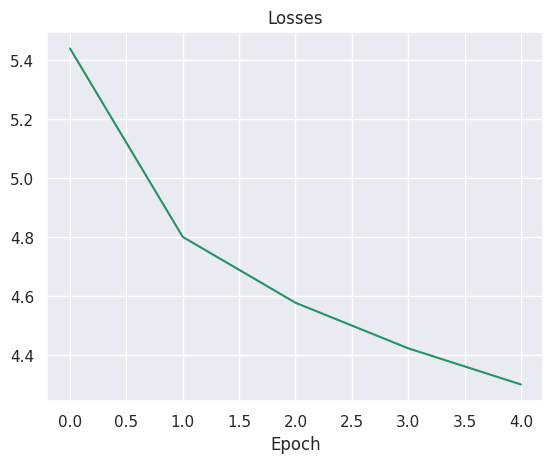

In [25]:
plt.plot(np.arange(len(loss_LSTM)), loss_LSTM)
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

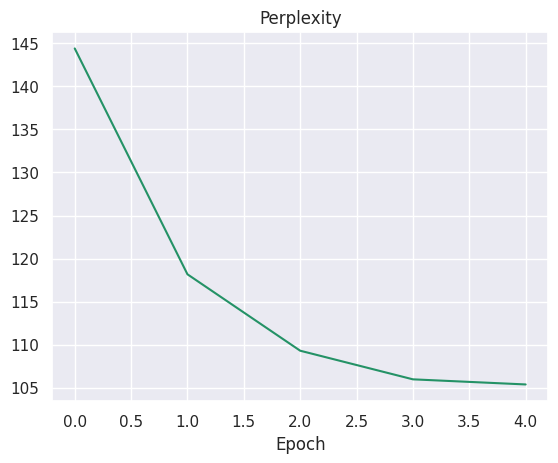

In [26]:
plt.plot(np.arange(len(plex_LSTM)), plex_LSTM)
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.show()



Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.
Попробую поменять drop_out 0.1 на 0,2 и 0,4

In [27]:
class LanguageModel_drop(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [28]:
# Проведите второй эксперимент
# подбор параметра drop out
dropouts = [0.2, 0.4]
dropout_plex = dict()
dropout_loss = dict()
for dropout_rate in dropouts:
    model = LanguageModel_drop(hidden_dim=256, vocab_size=len(vocab), dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    train_loss, train_plex = train_model(model, criterion, optimizer, num_epoch=5)
    dropout_plex[dropout_rate] = train_plex
    dropout_loss[dropout_rate] = train_loss

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Maximum test accuracy for 0.2 dropout rate: 147.9784767933381
Maximum test accuracy for 0.4 dropout rate: 195.33898681249374


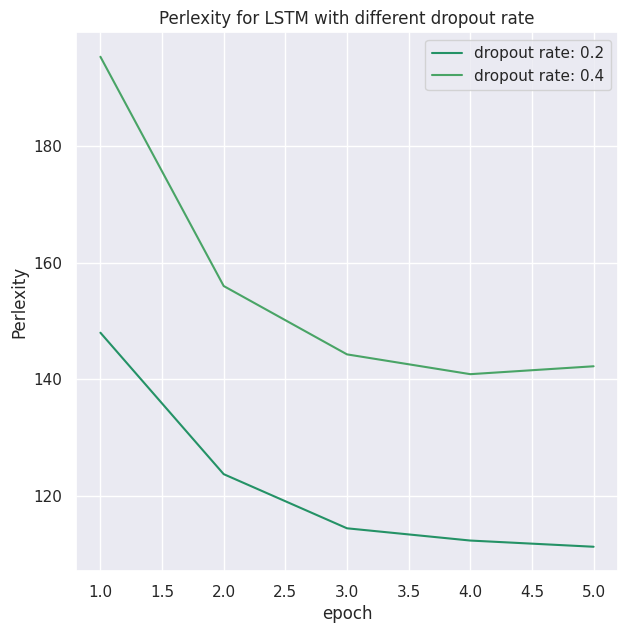

In [29]:
plt.figure(figsize=(7,7))
plt.xlabel('epoch')
plt.ylabel('Perlexity')
plt.title(f'Perlexity for LSTM with different dropout rate')
for key in dropout_plex.keys():
    curr_acc = dropout_plex[key]
    plt.plot(np.arange(len(curr_acc)) + 1, curr_acc, label=f'dropout rate: {str(key)}')
    print(f'Maximum test accuracy for {str(key)} dropout rate: {max(curr_acc)}')
plt.legend()
plt.show()

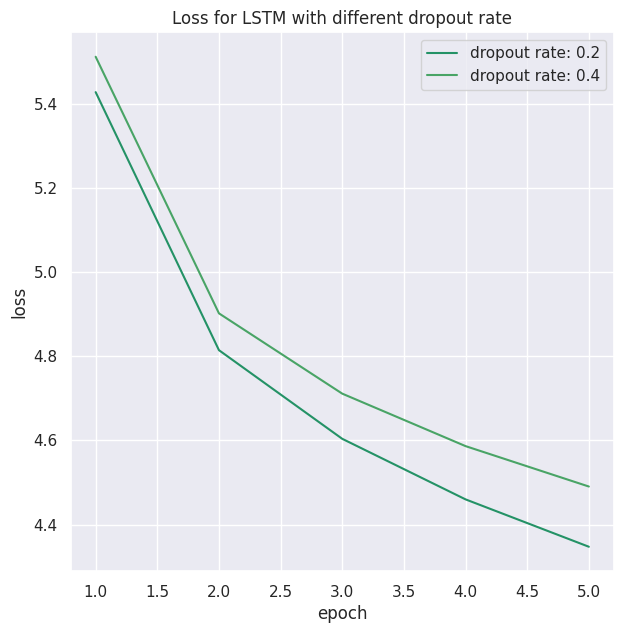

In [30]:
plt.figure(figsize=(7,7))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'Loss for LSTM with different dropout rate')
for key in dropout_loss.keys():
    curr_loss = dropout_loss[key]
    plt.plot(np.arange(len(curr_loss)) + 1, curr_loss, label=f'dropout rate: {str(key)}')
plt.legend()
plt.show()

все-таки в самом началае параметр drop_out= 0.1 показал наилучший результат как в лосс так и в перплексии

### Второй эксперимент (2 балла)
add batchnorm

In [31]:
class LanguageModel_layer_norm(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(self.layer_norm(output))))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(self.layer_norm(output)))  # [batch_size, seq_len, vocab_size]

        return projection

In [32]:
model_layer = LanguageModel_layer_norm(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_layer.parameters())
loss_LSTM_layer, plex_LSTM_layer = train_model(model_layer, criterion, optimizer, 5)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

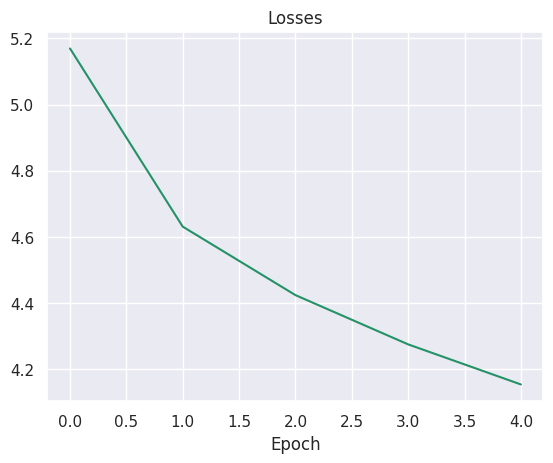

In [33]:
plt.plot(np.arange(len(loss_LSTM_layer)), loss_LSTM_layer)
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

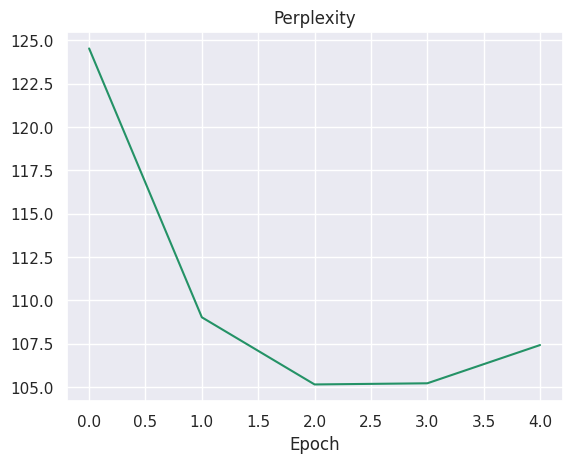

In [34]:
plt.plot(np.arange(len(plex_LSTM_layer)), plex_LSTM_layer)
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.show()

EX 3
GRU

In [47]:
class LanguageModel_GRU(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [48]:
model_GRU = LanguageModel_GRU(hidden_dim=256, vocab_size=len(vocab), dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GRU.parameters())
loss_GRU, plex_GRU = train_model(model_GRU, criterion, optimizer, 5)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

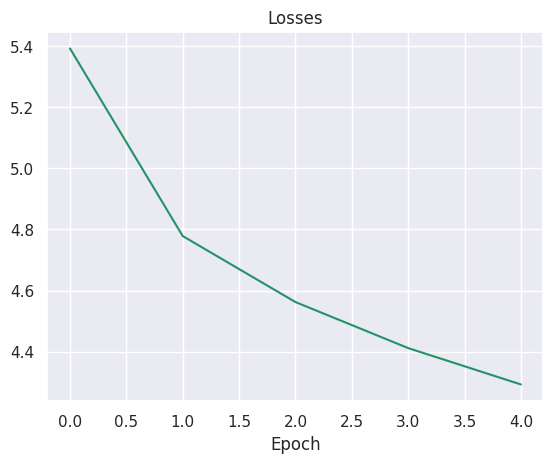

In [49]:
plt.plot(np.arange(len(loss_GRU)), loss_GRU)
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

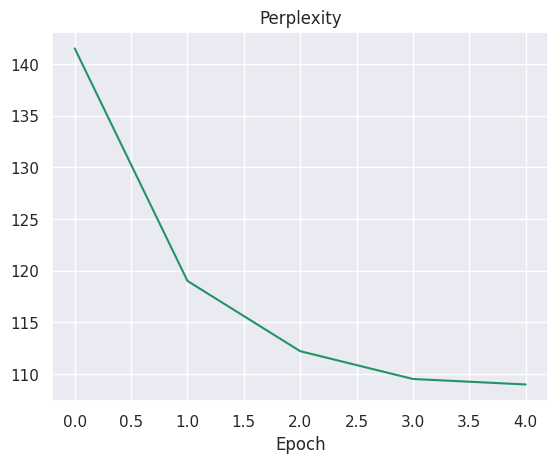

In [50]:
plt.plot(np.arange(len(plex_GRU)), plex_GRU)
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.show()

activation GeLU

In [21]:
class LanguageModel_GeLU(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.GELU()
        self.dropout = nn.Dropout(p=dropout_rate)

        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [22]:
model_GeLU = LanguageModel_GeLU(hidden_dim=256, vocab_size=len(vocab), dropout_rate=0.1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model_GeLU.parameters())
loss_GELU, plex_GELU = train_model(model_GeLU, criterion, optimizer, 5)

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

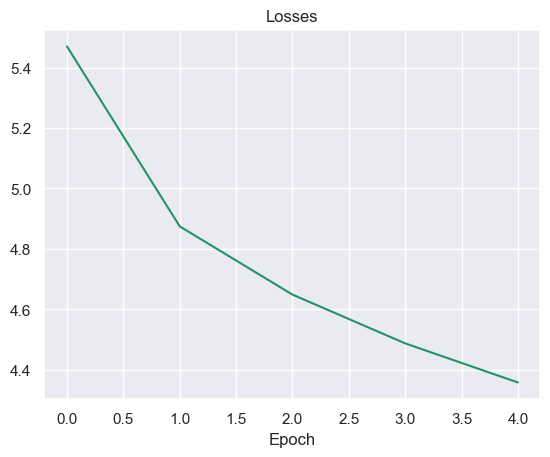

In [23]:
plt.plot(np.arange(len(loss_GELU)), loss_GELU)
plt.title('Losses')
plt.xlabel('Epoch')
plt.show()

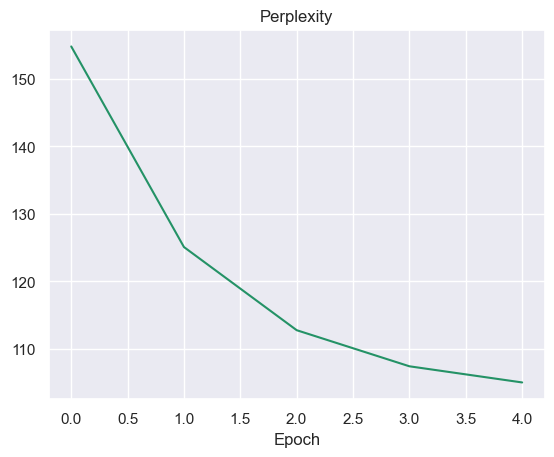

In [24]:
plt.plot(np.arange(len(plex_GELU)), plex_GELU)
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

1. LSTM c drop out 0.1
 LSTM c drop out 0.2, 0.4
Выбран лучший параметр drop out, т.е. в качестве первой модели выбрана модель LSTM c drop out = 0.1
2. К модели с наилучшим параметром drop out применяем layer_norm
3. Выбрана другая модель GRU
4. Другая функция активации GeLU (закончилось время в колабе и не получилось посчитать перплексию на тесте)

Layer_norm очень сильно улучшил результат, как и GRU. Возможно есть смысл попробовать в GRU добавить Layer_Norm. 

На самом деле вариантов много по улучшению метрики, также попробовать регулировать learning_rate. 



In [56]:
#pl1 = evaluate(model, criterion, test_dataloader)
pl1=140.3132592225686
#pl2 = evaluate(model_layer, criterion, test_dataloader)
pl2=106.28782692933694
#pl3 = evaluate(model_GRU, criterion, test_dataloader)
pl3=103.54027366638184
#

In [42]:
import pandas as pd

columns=['слой', 'activation', 'drop_out', 'layer_norm', 'perplexity']
rows=['model1', 'model2', 'model3']
data = np.array([['LSTM','tanh',0.1,'-', pl1], ['LSTM','tanh',0.1,'+', pl2], ['GRU','tanh',0.1,'-', pl3]])
df = pd.DataFrame(data=data, index=rows, columns=columns)
df

,слой,activation,drop_out,layer_norm,perplexity
model1,LSTM,tanh,0.1,-,140.3132592225686
model2,LSTM,tanh,0.1,+,106.28782692933694
model3,GRU,tanh,0.1,-,103.54027366638184


In [25]:
def generate_sequence(model, starting_seq: str, max_len: int = 15) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])
            #print(ind2word[input_ids[-1].item()])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [26]:
generate_sequence(model_GeLU, starting_seq='characters')

'<bos> characters are not a good actor . <eos>'

generate with beam_search

In [34]:
import torch.nn.functional as F
def generate_sequence_beam_search(model, starting_seq: str,
                                  dataset,
                                  max_seq_len: int = 128,
                                  beam_width: int = 3,
                                  device='cuda',
                                  temperature=1.0) -> str:
    model = model.to(device)
    initial_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    initial_ids = torch.LongTensor(initial_ids).to(device)

    beams = [(initial_ids, 0.0)]  # (sequence, log_prob)

    model.eval()
    with torch.no_grad():
        for _ in range(max_seq_len):
            new_beams = []
            for input_ids, log_prob in beams:
                next_word_distribution = model(input_ids)[-1]
                next_word_distribution = F.softmax(next_word_distribution / temperature, dim=-1)
                # Get top-k probabilities and indices
                top_probs, top_indices = torch.topk(next_word_distribution, beam_width)

                for prob, index in zip(top_probs, top_indices):
                    new_sequence = torch.cat([input_ids, index.unsqueeze(0)])
                    new_log_prob = log_prob + torch.log(prob).item()  # Log probabilities for numerical stability
                    new_beams.append((new_sequence, new_log_prob))

            # Sort new beams by log probability and select top-k
            new_beams.sort(key=lambda x: x[1], reverse=True)
            beams = new_beams[:beam_width]

            # Check if any beam reached <eos>
            finished_beams = [beam for beam in beams if beam[0][-1].item() == word2ind['<eos>']]
            if finished_beams:
                break  # Stop if any beam hits <eos>

    # Select the best finished beam, or the best overall beam if no beam finished
    best_beam = finished_beams[0] if finished_beams else beams[0]
    words = ' '.join([ind2word[idx.item()] for idx in best_beam[0]])

    return words

greedy search

In [31]:
def generate_sequenceT(model, starting_seq: str, dataset, max_seq_len: int = 128, device='cuda', temperature=1.0) -> str:
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word_distribution = F.softmax(next_word_distribution / temperature, dim=-1)
            next_word = torch.multinomial(next_word_distribution, 1).squeeze()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [37]:
promts = ['i was',
         "it's looks like",
         'how',
         'what is',
         'so,',
         'i have watched',
         'my girlfriend',
         'this ugly clown',
         'unfortunately'
         ]

def test_generation(promts, model, dataset):
    print('------- reedy, temp = 0.01 -------')
    for promt in promts:
        print(f'{promt}: {generate_sequenceT(model, promt, dataset, temperature=0.01)}')
        print(f'{promt}: {generate_sequenceT(model, promt, dataset, temperature=0.01)}')
    print('------- greedy, temp = 1 -------')
    for promt in promts:
        print(f'{promt}: {generate_sequenceT(model, promt, dataset,temperature=1)}')
        print(f'{promt}: {generate_sequenceT(model, promt, dataset, temperature=1)}')

    print('------- beam, temp = 0.01 -------')
    for promt in promts:
        print(f'{promt}: {generate_sequence_beam_search(model, promt, dataset, temperature=0.01)}')
        print(f'{promt}: {generate_sequence_beam_search(model, promt, dataset, temperature=0.01)}')
    print('------- beam, temp = 1 -------')
    for promt in promts:
        print(f'{promt}: {generate_sequence_beam_search(model, promt, dataset, temperature=1)}')
        print(f'{promt}: {generate_sequence_beam_search(model, promt, dataset, temperature=1)}')

In [38]:
test_generation(promts, model_GeLU, train_dataset)

------- reedy, temp = 0.01 -------
unfortunately: <bos> unfortunately , the movie is a bit of a film that is not a good movie . <eos>
unfortunately: <bos> unfortunately , the movie is a bit of a movie that is not worth the time . <eos>
------- greedy, temp = 1 -------
unfortunately: <bos> unfortunately , ms steiner is caught out as the widow , moves scenes for a stupid foe about the original lead did -- realistic looking the channel . <eos>
unfortunately: <bos> unfortunately , it will never be accused years . <eos>
------- beam, temp = 0.01 -------
unfortunately: <bos> unfortunately , the movie is a bit of a film that is not a good movie . <eos>
unfortunately: <bos> unfortunately , the movie is a bit of a film that is not a good movie . <eos>
------- beam, temp = 1 -------
unfortunately: <bos> unfortunately , it 's not a good movie . <eos>
unfortunately: <bos> unfortunately , it 's not a good movie . <eos>
